# 1. Import relevant Libraries

In [1]:
import re
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# 2. Functions

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    return text

In [3]:
def tokenise(doc):
    """
    Use spacy as the nlp object to tokenise each doc
    Lemmatise each words
    """
    return ' '.join([token.lemma_ for token in nlp(doc)])

In [13]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    """
    Use tokenised words to get vectors representations from the pretrained model (i.e. second_map).
    Average the vector representation of the description as the representation of the document 
    (i.e. each movie title's representation is the mean of vectors of each words in its description)
    """
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [79]:
def filter_df(keyword):
    """
    Return a dataframe with the filtered result.
    The input value is case-insensitive. 
    """
    if type(keyword) == list:
        return netflixDf.loc[netflixDf['title'].isin(keyword)]
    else:
        return netflixDf.loc[netflixDf['title'].str.lower().isin([keyword.lower()])]

In [103]:
def markerX(key, values):
    return netflixDf.loc[netflixDf[key].str.lower().isin(values)].sort_values(by='pca_2', ascending=False)

def others(key, values):
    return netflixDf.loc[~netflixDf[key].str.lower().isin(values)]

# 3. Analyse Pipeline

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

## Read the dataset/ Load the spacy pretrained model

In [54]:
netflixDf = pd.read_csv('finalDataset_v2.csv', usecols=['title','type','description','genres','originals'])

In [4]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Create the Corpus <br><br>Take out the special characters and stopwords. Lemmatise the words. <br><br>Mapping the corpus with title name

In [5]:
corpus = netflixDf.description.values.tolist() #list of docs

In [6]:
pp_corpus = [preprocess_text(doc) for doc in corpus] #preprocess the corpus

In [7]:
corpus_with_tkdocs = [tokenise(doc) for doc in pp_corpus] #tokenise and lemmatise the pp_corpus

In [8]:
# mapping out the title and each description. so later on i can search 
title_text = dict(zip(netflixDf['title'].str.lower().tolist(), corpus_with_tkdocs))
# lower the title (easy for search)

## Load the pretrained wiki model

In [11]:
# Use wikipedia trained model. It spends around 25 mins to load the model.
# w2v object is a dictionary like thing, in which each word has its own vector representation in 300-D.
MODEL_FILE = "enwiki_20180420_300d.txt"
w2v = KeyedVectors.load_word2vec_format(MODEL_FILE)

In [14]:
title_vec = get_vectors(title_text, w2v)

Now I have got all title's transformed into vector representations

## Dimension Reduction

### What if I use 80% of variance to do clustering. The only drawback is I can't visualise but it will be more accurate.

In [230]:
titles = netflixDf['title'].str.lower().tolist()
# Transform the vectors into an numpy array to feed to the pca model
vec = np.array([title_vec[title] for title in titles])
pca = PCA(n_components=11)
pca_result = pca.fit_transform(vec)
ttl_variation = round(sum(pca.explained_variance_ratio_),2)*100
print(f'Explained variation per principal component: {ttl_variation}')
print("Each component accounts for: ")
pprint(pca.explained_variance_ratio_)

Explained variation per principal component: 80.0
Each component accounts for: 
array([0.16878065, 0.14112122, 0.09121057, 0.0724477 , 0.05999166,
       0.05865822, 0.05316899, 0.04600625, 0.04269569, 0.03736011,
       0.03238226], dtype=float32)


In [227]:
sum_li = []
variance = pca.explained_variance_ratio_
for i in range(len(variance)):
    sum_li.append(sum(variance[0:i+1]))

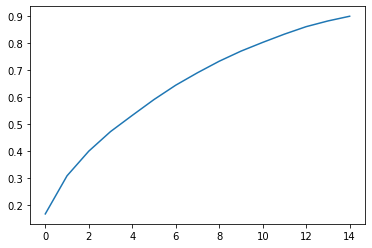

In [231]:
plt.plot(range(15), sum_li);

In [56]:
netflixDf['pca_1'] = pca_result[:,0]
netflixDf['pca_2'] = pca_result[:,1]

## Show preliminary result of pca graph

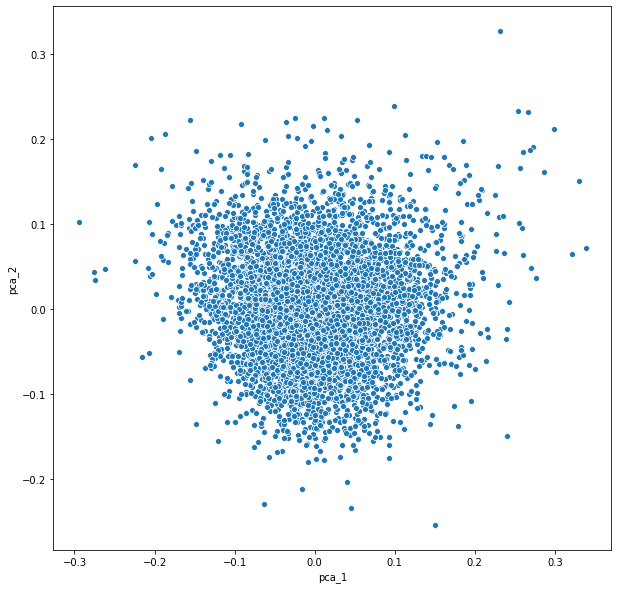

In [58]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca_1',
                y = 'pca_2',
                data = netflixDf)
plt.show()

## Determine k value using elbow methods.<br>plot a colored graph

In [60]:
wcss = dict()

kmean_df = netflixDf[['pca_1','pca_2']]
for i in range(1,50):
    k = KMeans(n_clusters=i, init='k-means++').fit(kmean_df)
    wcss_iter = k.inertia_
    wcss[i] = wcss_iter

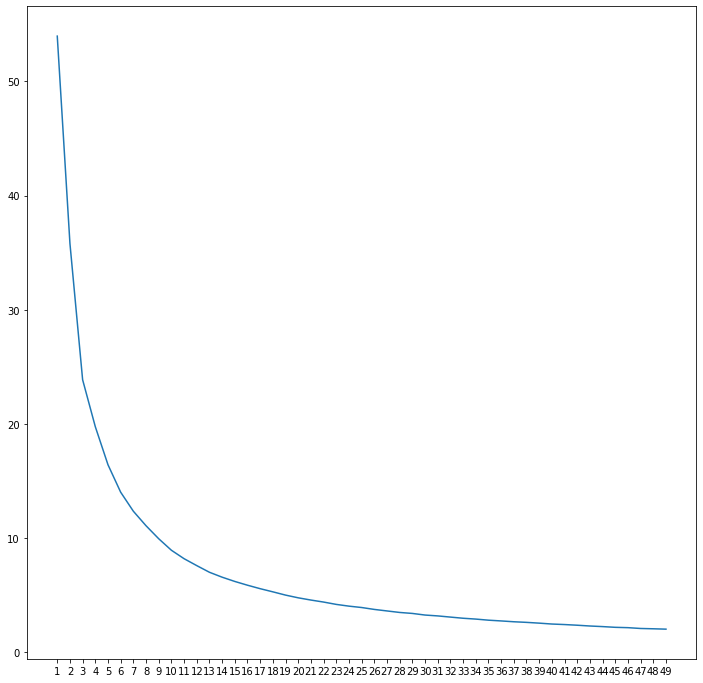

In [65]:
plt.figure(figsize=(12,12))
sns.lineplot(x=list(wcss.keys()), 
             y=list(wcss.values()))
plt.xticks(range(1,len(list(wcss.keys()))+1))
plt.show()

## Train Kmeans model

In [99]:
N_CLUSTERS = 11
kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++').fit(netflixDf[['pca_1','pca_2']])

LABELS = kmeans.predict(netflixDf[['pca_1','pca_2']])
CENTROIDS = kmeans.cluster_centers_

netflixDf['kmean_label'] = LABELS

# Some descriptive tables

In [170]:
org_by_cluster = netflixDf[['kmean_label','originals']].groupby('kmean_label').sum()

ttl_num_org = sum(org_by_cluster.originals)
org_by_cluster = org_by_cluster.apply(lambda x: (x/ttl_num_org))
org_by_cluster = org_by_cluster.reset_index()

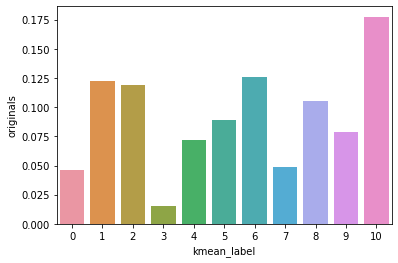

In [172]:
plt.figure()
sns.barplot(x = 'kmean_label', y = 'originals', data = org_by_cluster)
plt.show()

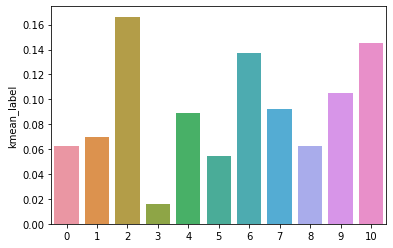

In [152]:
count_by_cluster = netflixDf.kmean_label.value_counts(sort=True, normalize=True)
sns.barplot(x = count_by_cluster.index, y = count_by_cluster)

<BarContainer object of 11 artists>

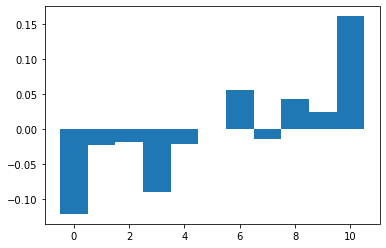

In [184]:
diff = np.array(org_by_cluster.originals) - np.array(count_by_cluster)
plt.figure()
x = range(11)
plt.bar(x,diff, width=1)

## Visualise with pca

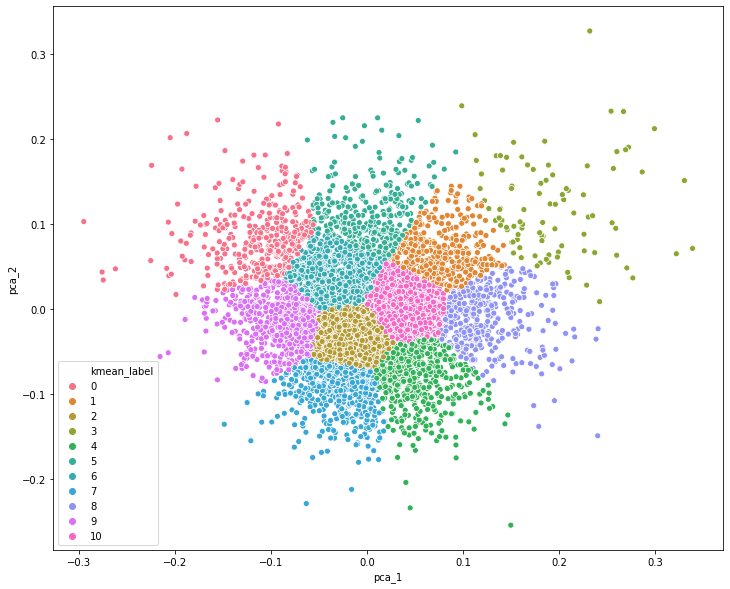

In [102]:
plt.figure(figsize=(12,10))
sns.scatterplot(x = 'pca_1',
                y = 'pca_2',
                hue = 'kmean_label',
                data = netflixDf,
                palette = sns.color_palette("husl", N_CLUSTERS),
                legend = 'full')
plt.show()

## Assign top 10 movies and tvshows to variables

In [81]:
top_10_movie = [
    'Bird Box',
    'Murder Mystery',
    'Triple Frontier',
    'The Perfect Date',
    'Tall Girl',
    'The Highwaymen',
    'Secret Obsession',
    'Always Be My Maybe',
    'Otherhood',
    'FYRE: The Greatest Party That Never Happened'
]

top_10_tvshow = [
    'Stranger Things',
    'The Umbrella Academy',
    'Money Heist',
    'You',
    'Sex Education',
    'Our Planet',
    'Unbelievable',
    'Dead to Me',
    'When They See Us',
    'Elite'
]
top_10_movie = [i.lower() for i in top_10_movie]
top_10_tvshow = [i.lower() for i in top_10_tvshow]

## Originals in plots

In [ ]:
org_df = netflixDf.loc[netflixDf['originals']==1]
others_df = netflixDf.loc[netflixDf['originals']==0]


plt.figure(figsize=(20,20))

others_plot = sns.scatterplot(x = 'pca_1',
                              y = 'pca_2',
                              hue = 'kmean_label',
                              data = others_df,
                              palette = sns.color_palette("husl", N_CLUSTERS),
                              legend = "full",
                              alpha = 0.95
                             )

originals = sns.scatterplot(x = 'pca_1',
                           y = 'pca_2',
                           data = org_df,
                           color = 'black',
                           marker = 'X',
                           alpha = 1
                             )
plt.show()

## Top 10 tvshow in plots

In [185]:
top_10_tvshow_df

,title,genres,description,type,originals,pca_1,pca_2,kmean_label
4172,Dead to Me,"comedy,drama,mystery,crime","A hotheaded widow searching for the hit-and-run driver who mowed down her husband befriends an eccentric optimist who isn't quite what she seems.Dead to Me featuring Christina Applegate and Linda Cardellini has one or more episodes streaming with subscription on Netflix. It's a comedy and crime show with 20 episodes over 2 seasons. Dead to Me is still airing with no announced date for the next episode or season. It has a high Rotten Tomatoes (critics) score of 90% and a high IMDb audience rating of 8.1 (45,787 votes).",tvshow,1,0.042433,0.067118,1
5164,Sex Education,"comedy,drama","Inexperienced Otis channels his sex therapist mom when he teams up with rebellious Maeve to set up an underground sex therapy clinic at school.Sex Education featuring Asa Butterfield and Gillian Anderson has one or more episodes streaming with subscription on Netflix. It's a comedy and drama show with 16 episodes over 2 seasons. Sex Education is still airing with no announced date for the next episode or season. It has a very high Rotten Tomatoes (critics) score of 94% and a high IMDb audience rating of 8.3 (136,547 votes).",tvshow,1,0.100180,0.065750,1
5264,Stranger Things,"drama,fantasy,horror,mystery,science-fiction,thriller,action-and-adventure","When a young boy vanishes, a small town uncovers a mystery involving secret experiments, terrifying supernatural forces, and one strange little girl.Stranger Things featuring Winona Ryder and David Harbour has one or more episodes streaming with subscription on Netflix. It's an action & adventure and drama show with 25 episodes over 3 seasons. Stranger Things is still airing with no announced date for the next episode or season. It has a very high Rotten Tomatoes (critics) score of 93% and a high IMDb audience rating of 8.8 (749,209 votes).",tvshow,1,0.037253,0.037054,10
4253,Elite,"crime,drama,thriller,mystery","When three working class kids enroll in the most exclusive school in Spain, the clash between the wealthy and the poor students leads to tragedy.Elite featuring Itzan Escamilla and Mina El Hammani has one or more episodes streaming with subscription on Netflix. It's a crime and drama show with 24 episodes over 3 seasons. Elite is still airing with no announced date for the next episode or season. It has a very high Rotten Tomatoes (critics) score of 97% and a high IMDb audience rating of 7.6 (39,597 votes).",tvshow,1,0.054276,0.027587,10
4964,Our Planet,documentary,"Experience our planet's natural beauty and examine how climate change impacts all living creatures in this ambitious documentary of spectacular scope.Our Planet featuring David Attenborough has one or more episodes streaming with subscription on Netflix. It's a documentary show with 8 episodes over 1 season. Our Planet is no longer running and has no plans to air new episodes or seasons. It has a very high Rotten Tomatoes (critics) score of 93% and a very high IMDb audience rating of 9.3 (26,659 votes).",tvshow,1,0.044047,0.027418,10
4832,Money Heist,"thriller,action-and-adventure,crime,mystery,drama","To carry out the biggest heist in history, a mysterious man called The Professor recruits a band of eight robbers who have a single characteristic: none of them has anything to lose. Five months of seclusion - memorizing every step, every detail, every probability - culminate in eleven days locked up in the National Coinage and Stamp Factory of Spain, surrounded by police forces and with dozens of hostages in their power, to find out whether their suicide wager will lead to everything or nothing.Money Heist featuring Úrsula Corberó and Álvaro Morte has one or more episodes streaming with subscription on Netflix. It's an action & adventure and crime show with 38 episodes over 2 seasons. Money Heist is still airing with no announced date for the next episode or season. It has a very high Rotten Tomatoes (critics) score of 93% a

In [187]:
def annotate(df, label):
    x = df.loc[df['kmean_label']==label]['pca_1'].tolist()
    y = df.loc[df['kmean_label']==label]['pca_2'].tolist()
    titles = df.loc[df['kmean_label']==label]['title'].tolist()
    return(x,y,titles)

In [190]:
x1,y1,t1 = annotate(top_10_tvshow_df, 1)
x1

[0.04243285208940506, 0.1001804992556572]

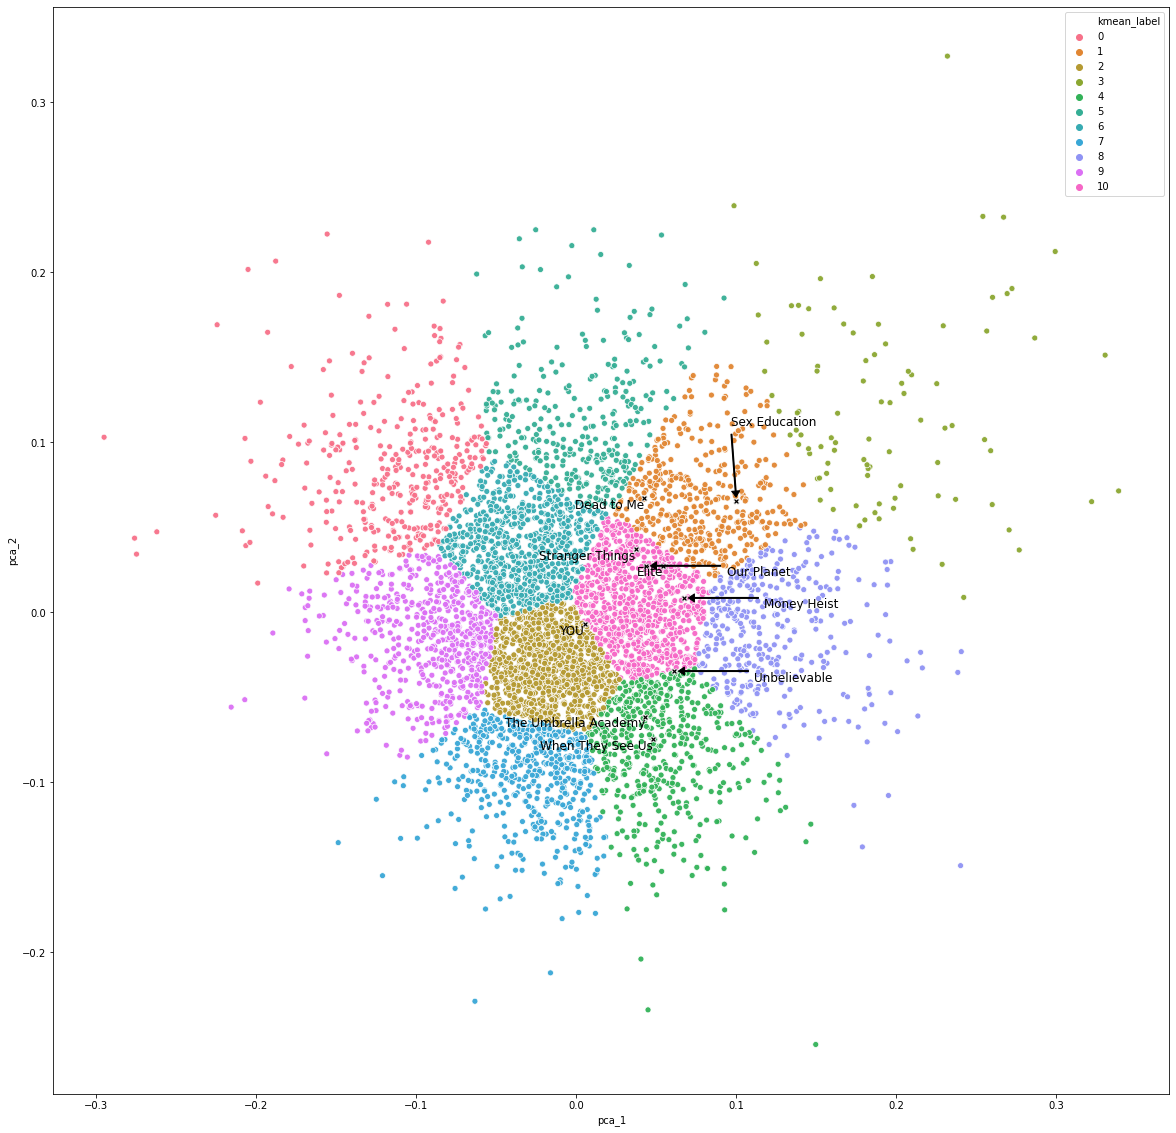

In [204]:
top_10_tvshow_df = markerX('title', top_10_tvshow)
others_df = others('title', top_10_tvshow)

plt.figure(figsize=(20,20))

others_plot = sns.scatterplot(x = 'pca_1',
                              y = 'pca_2',
                              hue = 'kmean_label',
                              data = others_df,
                              palette = sns.color_palette("husl", N_CLUSTERS),
                              legend = "full",
                              alpha = 0.95
                             )

tvshow_10 = sns.scatterplot(x = 'pca_1',
                           y = 'pca_2',
                           data = top_10_tvshow_df,
                           color = 'black',
                           marker = 'X',
                           alpha = 1
                             )

x1,y1,t1 = annotate(top_10_tvshow_df, 1)
x2,y2,t2 = annotate(top_10_tvshow_df, 2)
x4,y4,t4 = annotate(top_10_tvshow_df, 4)
x10,y10,t10 = annotate(top_10_tvshow_df, 10)
size = 12
for i in range(len(x1)):
    if i == 0:
        plt.annotate(t1[i],
                    xy=(x1[i],y1[i]), xycoords='data',
                    xytext = (x1[i],y1[i]),
                    textcoords='data',
                    size=size,
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, headlength=6),
                    horizontalalignment='right', verticalalignment='top')
    else:
        plt.annotate(t1[i],
                    xy=(x1[i],y1[i]), xycoords='data',
                    xytext = (x1[i]+0.05,y1[i]+0.05),
                    textcoords='data',
                    size=size,
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, headlength=6),
                    horizontalalignment='right', verticalalignment='top')

plt.annotate(t2[0],
            xy=(x2[0],y2[0]), xycoords='data',
            xytext = (x2[0],y2[0]),
            textcoords='data',
            size=size,
            horizontalalignment='right', verticalalignment='top')
for i in range(len(x4)):
    plt.annotate(t4[i],
                xy=(x4[i],y4[i]), xycoords='data',
                xytext = (x4[i],y4[i]),
                textcoords='data',
                size=size,
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, headlength=6),
                horizontalalignment='right', verticalalignment='top')

for i in range(len(x10)):
    if i < 2:
        plt.annotate(t10[i],
                    xy=(x10[i],y10[i]), xycoords='data',
                    xytext = (x10[i],y10[i]),
                    textcoords='data',
                    size=size,
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, headlength=6),
                    horizontalalignment='right', verticalalignment='top')
    else:
        plt.annotate(t10[i],
                    xy=(x10[i],y10[i]), xycoords='data',
                    xytext = (x10[i]+0.05,y10[i]),
                    textcoords='data',
                    size=size,
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8, headlength=6),
                    horizontalalignment='left', verticalalignment='top')
plt.show()